## 1) Business Understanding

Income inequality is not only a social and ethical concern—it has direct implications for economic stability, consumer behavior, and long-term development. By understanding and predicting the Gini Index, governments, NGOs, and development banks can better allocate resources, design targeted interventions, and monitor progress toward inclusive growth.

This project addresses a key question: **Can we use publicly available development indicators to anticipate which countries are most at risk of income inequality?** If successful, such a model could support data-driven policy planning and contribute to more equitable and sustainable economic outcomes.

Other questions to ask:

2. **Which development indicators are the most predictive of income inequality?**  
   The project evaluates feature importance to highlight key drivers like poverty rates and access to healthcare.

3. **How well does a machine learning model perform in classifying inequality levels across countries?**  
   The model’s test and train accuracy are analyzed to assess generalization.

4. **Are there signs of overfitting or bias in predicting inequality for specific country groups?**  
   By comparing training and test results, we check for robustness and fairness.

5. **Which domains—poverty, health, infrastructure, demographics—contribute most to explaining inequality?**  
   The analysis groups features into domains to identify structural patterns in inequality.


## 2) Data Understanding


The dataset includes over 7,500 rows and 122 indicators across more than 100 countries, spanning from 1980 to 2024. Each row represents a unique combination of country, indicator, and year, making the data suitable for time series or panel data analysis.

### Data Sources and Structure

The data originate from World Bank. Indicators were selected from domains such as:
- Poverty and inequality (e.g., Gini index, poverty headcount ratios)
- Health (e.g., HIV prevalence, surgical coverage, suicide rates)
- Infrastructure (e.g., access to electricity, water, sanitation)
- Financial inclusion (e.g., account ownership by gender)
- Economic structure (e.g., GDP, tax revenue, population density)

Each indicator is accompanied by metadata that includes:
- Full and short definitions
- Units of measure (mostly percentages)
- Periodicity (mostly annual or triennial)
- Methodological notes and data source links

### Gini Index (Target Variable)

The Gini index, the project's prediction target, is defined as:
> “A measure of statistical dispersion intended to represent the income inequality within a nation or a social group.”

It is sourced from the World Bank’s Poverty and Inequality Platform and is expressed as a percentage (0 = perfect equality, 100 = maximum inequality).

### Data Quality

- Most indicators have consistent annual updates from the 1990s onward.
- Missing values are present but limited in key indicators used for modeling.
- The metadata provides methodological transparency, ensuring reproducibility and interpretability.

This comprehensive and well-documented dataset forms a robust foundation for understanding and predicting global inequality patterns.


## Data Preparation

In [41]:
!pip install openpyxl


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [43]:
df_upload=pd.read_excel('WorldBank_Data_1.xlsx', sheet_name='Data')

In [44]:
df_upload.head()

,Country Name,Country Code,Continent,Series Name,Series Code,1980 [YR1980],1981 [YR1981],1982 [YR1982],1983 [YR1983],1984 [YR1984],...,2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023],2024 [YR2024]
0,Albania,ALB,Europe,Gini index,SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,...,32.8,33.7,33.10,30.1,30.1,29.4,NaN,NaN,NaN,NaN
1,Albania,ALB,Europe,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,...,100.0,99.9,99.90,100.0,100.0,100.0,100.00,100.0,100.0,NaN
2,Albania,ALB,Europe,Account ownership at a financial institution o...,FX.OWN.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,40.02,NaN,NaN,NaN,44.17,NaN,NaN,NaN
3,Albania,ALB,Europe,Account ownership at a financial institution o...,FX.OWN.TOTL.FE.ZS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,38.10,NaN,NaN,NaN,45.69,NaN,NaN,NaN
4,Albania,ALB,Europe,Account ownership at a financial institution o...,FX.OWN.TOTL.MA.ZS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,42.04,NaN,NaN,NaN,42.59,NaN,NaN,NaN


In [45]:
# Make a list of columns with indicators data
year_columns=[col for col in df_upload.columns if col.startswith('19') or col.startswith('20') ]

In [46]:
# Check Target variable for nulls
gini_null_df=df_upload[df_upload['Series Name']=='Gini index']
gini_null_count=gini_null_df[year_columns].isnull().sum().sum()
print(gini_null_count)

5456


In [47]:
# Check all variables for nulls
print(df_upload.isnull().sum().sum())

528502


In [48]:
'''I will fill null values
Country charactertics don't change much and are stable over time usually that's why first I am going to use forth progpagation
and then back propagation for what is missing. I will do it for whole dataset'''
df_cols_to_fill_only=df_upload[year_columns].copy()
df_cols_to_fill_only=df_cols_to_fill_only[year_columns].ffill(axis=1)
df_cols_to_fill_only=df_cols_to_fill_only[year_columns].bfill(axis=1)
# For remaing nulls left - whole row must have only null values - I will fill them in with 0
df_cols_to_fill_only=df_cols_to_fill_only[year_columns].fillna(0)
df_upload[year_columns]=df_cols_to_fill_only
df_upload.head()

,Country Name,Country Code,Continent,Series Name,Series Code,1980 [YR1980],1981 [YR1981],1982 [YR1982],1983 [YR1983],1984 [YR1984],...,2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023],2024 [YR2024]
0,Albania,ALB,Europe,Gini index,SI.POV.GINI,27.00,27.00,27.00,27.00,27.00,...,32.80,33.70,33.10,30.10,30.10,29.40,29.40,29.40,29.40,29.40
1,Albania,ALB,Europe,Access to electricity (% of population),EG.ELC.ACCS.ZS,100.00,100.00,100.00,100.00,100.00,...,100.00,99.90,99.90,100.00,100.00,100.00,100.00,100.00,100.00,100.00
2,Albania,ALB,Europe,Account ownership at a financial institution o...,FX.OWN.TOTL.ZS,28.27,28.27,28.27,28.27,28.27,...,37.99,37.99,40.02,40.02,40.02,40.02,44.17,44.17,44.17,44.17
3,Albania,ALB,Europe,Account ownership at a financial institution o...,FX.OWN.TOTL.FE.ZS,22.67,22.67,22.67,22.67,22.67,...,33.59,33.59,38.10,38.10,38.10,38.10,45.69,45.69,45.69,45.69
4,Albania,ALB,Europe,Account ownership at a financial institution o...,FX.OWN.TOTL.MA.ZS,33.66,33.66,33.66,33.66,33.66,...,42.52,42.52,42.04,42.04,42.04,42.04,42.59,42.59,42.59,42.59


In [49]:
# I will check if there are no nulls left
print(df_upload.isnull().sum().sum())

0


In [50]:
# Veiw dataset without nulls
df_upload.head()

,Country Name,Country Code,Continent,Series Name,Series Code,1980 [YR1980],1981 [YR1981],1982 [YR1982],1983 [YR1983],1984 [YR1984],...,2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023],2024 [YR2024]
0,Albania,ALB,Europe,Gini index,SI.POV.GINI,27.00,27.00,27.00,27.00,27.00,...,32.80,33.70,33.10,30.10,30.10,29.40,29.40,29.40,29.40,29.40
1,Albania,ALB,Europe,Access to electricity (% of population),EG.ELC.ACCS.ZS,100.00,100.00,100.00,100.00,100.00,...,100.00,99.90,99.90,100.00,100.00,100.00,100.00,100.00,100.00,100.00
2,Albania,ALB,Europe,Account ownership at a financial institution o...,FX.OWN.TOTL.ZS,28.27,28.27,28.27,28.27,28.27,...,37.99,37.99,40.02,40.02,40.02,40.02,44.17,44.17,44.17,44.17
3,Albania,ALB,Europe,Account ownership at a financial institution o...,FX.OWN.TOTL.FE.ZS,22.67,22.67,22.67,22.67,22.67,...,33.59,33.59,38.10,38.10,38.10,38.10,45.69,45.69,45.69,45.69
4,Albania,ALB,Europe,Account ownership at a financial institution o...,FX.OWN.TOTL.MA.ZS,33.66,33.66,33.66,33.66,33.66,...,42.52,42.52,42.04,42.04,42.04,42.04,42.59,42.59,42.59,42.59


In [51]:
# For Random forest I will need each feture in a column and Year in a rows -> so I will need to change the structure

df_upload=df_upload.drop('Series Code', axis=1)
df_step_1=df_upload.melt(id_vars=['Country Name', 'Country Code', 'Series Name','Continent'],var_name="Year", value_name="Value").copy()
# Clean Year name
df_step_1['Year'] = df_step_1['Year'].str[:4]

df=df_step_1.pivot_table(index=['Country Name', 'Country Code','Continent','Year'],
           columns='Series Name',
           values='Value',
           aggfunc='first').reset_index()

In [52]:
# Check if the structure is correct
df.head(10)

Series Name,Country Name,Country Code,Continent,Year,Access to electricity (% of population),Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)","Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+)",Adequacy of social insurance programs (% of total welfare of beneficiary households),"Birth rate, crude (per 1,000 people)",...,"Share of youth not in education, employment or training, total (% of youth population)","Specialist surgical workforce (per 100,000 population)","Suicide mortality rate (per 100,000 population)",Tax revenue (current LCU),Taxes on exports (% of tax revenue),Taxes on goods and services (current LCU),"Taxes on income, profits and capital gains (% of revenue)","Women participating in the three decisions (own health care, major household purchases, and visiting family) (% of women age 15-49)",Women who were first married by age 15 (% of women ages 20-24),Women who were first married by age 18 (% of women ages 20-24)
0,Albania,ALB,Europe,1980,100.0,28.27,22.67,33.66,29.186345,26.756,...,41.805,7.07,4.78,3.016700e+10,0.000913,1.885000e+10,8.319688,58.8,0.2,9.6
1,Albania,ALB,Europe,1981,100.0,28.27,22.67,33.66,29.186345,26.476,...,41.805,7.07,4.78,3.016700e+10,0.000913,1.885000e+10,8.319688,58.8,0.2,9.6
2,Albania,ALB,Europe,1982,100.0,28.27,22.67,33.66,29.186345,26.575,...,41.805,7.07,4.78,3.016700e+10,0.000913,1.885000e+10,8.319688,58.8,0.2,9.6
3,Albania,ALB,Europe,1983,100.0,28.27,22.67,33.66,29.186345,26.442,...,41.805,7.07,4.78,3.016700e+10,0.000913,1.885000e+10,8.319688,58.8,0.2,9.6
4,Albania,ALB,Europe,1984,100.0,28.27,22.67,33.66,29.186345,26.513,...,41.805,7.07,4.78,3.016700e+10,0.000913,1.885000e+10,8.319688,58.8,0.2,9.6
5,Albania,ALB,Europe,1985,100.0,28.27,22.67,33.66,29.186345,26.464,...,41.805,7.07,4.78,3.016700e+10,0.000913,1.885000e+10,8.319688,58.8,0.2,9.6
6,Albania,ALB,Europe,1986,100.0,28.27,22.67,33.66,29.186345,26.312,...,41.805,7.07,4.78,3.016700e+10,0.000913,1.885000e+10,8.319688,58.8,0.2,9.6
7,Albania,ALB,Europe,1987,100.0,28.27,22.67,33.66,29.186345,26.260,...,41.805,7.07,4.78,3.016700e+10,0.000913,1.885000e+10,8.319688,58.8,0.2,9.6
8,Albania,ALB,Europe,1988,100.0,28.27,22.67,33.66,29.186345,26.214,...,41.805,7.07,4.78,3.016700e+10,0.000913,1.885000e+10,8.319688,58.8,0.2,9.6
9,Albania,ALB,Europe,1989,100.0,28.27,22.67,33.66,29.186345,26.179,...,41.805,7.07,4.78,3.016700e+10,0.000913,1.885000e+10,8.319688,58.8,0.2,9.6


In [53]:
# Check for duplicates
duplicates = df.duplicated(subset=['Country Name', 'Country Code', 'Continent', 'Year'])

# Zwróć tylko zduplikowane wiersze
duplicate_rows = df[duplicates]
duplicate_rows

Series Name,Country Name,Country Code,Continent,Year,Access to electricity (% of population),Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)","Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+)",Adequacy of social insurance programs (% of total welfare of beneficiary households),"Birth rate, crude (per 1,000 people)",...,"Share of youth not in education, employment or training, total (% of youth population)","Specialist surgical workforce (per 100,000 population)","Suicide mortality rate (per 100,000 population)",Tax revenue (current LCU),Taxes on exports (% of tax revenue),Taxes on goods and services (current LCU),"Taxes on income, profits and capital gains (% of revenue)","Women participating in the three decisions (own health care, major household purchases, and visiting family) (% of women age 15-49)",Women who were first married by age 15 (% of women ages 20-24),Women who were first married by age 18 (% of women ages 20-24)


In [54]:

def summarize_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Purpose: to print information resembling info() when there are to many variables for info() to work
    Generate a summary of a DataFrame, including data types, number of null values,
    number of non-null values, and number of unique values per column.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame to summarize.

    Returns:
    --------
    pd.DataFrame
        A summary DataFrame sorted by the number of null values in descending order,
        with columns: 'dtype', 'nulls', 'non_nulls', 'unique'.
    """
    summary = pd.DataFrame({
        'dtype': df.dtypes,
        'nulls': df.isnull().sum(),
        'non_nulls': df.notnull().sum(),
        'unique': df.nunique()
    }).sort_values(by='nulls', ascending=False)

    return summary

In [55]:
print(summarize_dataframe(df))

                                                      dtype  nulls  non_nulls  \
Series Name                                                                     
Country Name                                         object      0       7515   
Country Code                                         object      0       7515   
Continent                                            object      0       7515   
Year                                                 object      0       7515   
Access to electricity (% of population)             float64      0       7515   
...                                                     ...    ...        ...   
Taxes on goods and services (current LCU)           float64      0       7515   
Taxes on income, profits and capital gains (% o...  float64      0       7515   
Women participating in the three decisions (own...  float64      0       7515   
Women who were first married by age 15 (% of wo...  float64      0       7515   
Women who were first married

In [56]:
# View desrptions of feautres
df.describe()

Series Name,Access to electricity (% of population),Account ownership at a financial institution or with a mobile-money-service provider (% of population ages 15+),"Account ownership at a financial institution or with a mobile-money-service provider, female (% of population ages 15+)","Account ownership at a financial institution or with a mobile-money-service provider, male (% of population ages 15+)",Adequacy of social insurance programs (% of total welfare of beneficiary households),"Birth rate, crude (per 1,000 people)","Cause of death, by injury (% of total)","Condom use, population ages 15-24, female (% of females ages 15-24)","Condom use, population ages 15-24, male (% of males ages 15-24)",Coverage of social insurance programs (% of population),...,"Share of youth not in education, employment or training, total (% of youth population)","Specialist surgical workforce (per 100,000 population)","Suicide mortality rate (per 100,000 population)",Tax revenue (current LCU),Taxes on exports (% of tax revenue),Taxes on goods and services (current LCU),"Taxes on income, profits and capital gains (% of revenue)","Women participating in the three decisions (own health care, major household purchases, and visiting family) (% of women age 15-49)",Women who were first married by age 15 (% of women ages 20-24),Women who were first married by age 18 (% of women ages 20-24)
count,7515.000000,7515.000000,7515.000000,7515.000000,7515.000000,7515.000000,7515.000000,7515.000000,7515.000000,7515.000000,...,7515.000000,7515.000000,7515.000000,7.515000e+03,7515.000000,7.515000e+03,7515.000000,7515.000000,7515.000000,7515.000000
mean,73.663620,42.680551,40.331634,45.114802,18.477456,25.667153,8.360060,6.223313,13.654145,11.858307,...,23.028393,32.136532,10.088614,5.054185e+12,1.357497,1.889683e+12,18.763983,19.240027,4.718816,18.790832
std,33.540630,33.374648,33.753690,33.399152,19.449547,12.482374,4.293425,12.368619,22.026384,16.770977,...,13.096747,37.297560,8.256649,3.770599e+13,5.358458,1.443263e+13,13.368240,27.259940,7.101313,18.291650
min,0.533899,0.000000,0.000000,0.000000,0.000000,4.500000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,-25.224244,0.000000e+00,-1.350857,0.000000,0.000000,0.000000
25%,48.900000,14.900000,10.880000,17.280000,0.000000,13.900000,5.866635,0.000000,0.000000,0.000000,...,12.940000,1.410000,4.630000,6.770500e+08,0.000000,2.038700e+08,9.839912,0.000000,0.000000,0.100000
50%,94.600000,33.670000,29.160000,39.200000,15.473152,24.180000,7.581927,0.000000,0.000000,3.259231,...,21.321000,13.090000,7.590000,2.747800e+10,0.000165,1.321327e+10,18.179968,0.000000,1.800000,15.300000
75%,100.000000,73.490000,71.270000,75.460000,31.506591,36.063500,10.165098,7.100000,24.600000,17.673357,...,31.158500,59.320000,13.310000,3.274800e+11,0.284626,1.452688e+11,26.801971,39.300000,6.800000,30.300000
max,100.000000,100.000000,100.000000,100.000000,96.405021,56.596000,73.428775,66.000000,79.200000,60.233127,...,79.549000,166.810000,53.060000,6.587010e+14,51.677005,2.664720e+14,78.012685,92.800000,50.300000,83.500000


I will check how target variable looks like

Text(0.5, 1.0, 'Ditribution of Gini Index')

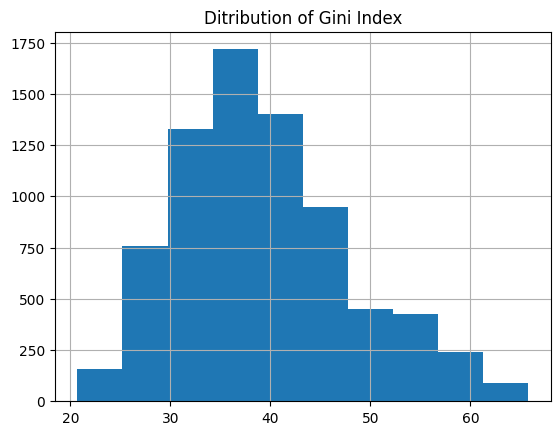

In [57]:

df['Gini index'].hist()
plt.title('Ditribution of Gini Index')

Since the goal is to build a classification model using a Random Forest algorithm, the continuous Gini Index values will be grouped into discrete bins with a width of 0.1.

In [58]:
bins=np.arange(0,110,10)
labels_gini=[f'{round(i,1)} - {round(i+10,1)}' for i in np.arange(0,100,10)]

df['Gini_index_bins']=pd.cut(df['Gini index'],bins=bins,labels=labels_gini)

In [59]:
# Check if bins are correct
print(df[['Gini index','Gini_index_bins']].drop_duplicates())

Series Name  Gini index Gini_index_bins
0                  27.0         20 - 30
22                 31.7         30 - 40
25                 30.6         30 - 40
28                 30.0         20 - 30
32                 29.0         20 - 30
...                 ...             ...
6549               42.5         40 - 50
6959               44.2         40 - 50
6962               41.0         40 - 50
7010               25.5         20 - 30
7425               59.4         50 - 60

[372 rows x 2 columns]


In [60]:
df['Gini_index_bins'].value_counts()

Gini_index_bins
30 - 40     3371
40 - 50     2166
20 - 30     1005
50 - 60      840
60 - 70      133
0 - 10         0
10 - 20        0
70 - 80        0
80 - 90        0
90 - 100       0
Name: count, dtype: int64

I will fix issues with independent variables 

In [61]:
# Continent can be an issue, beacause some observation have 0, I need to fix it
df.Continent.value_counts()

Continent
Africa           2250
Europe           1800
Asia             1620
North America     720
South America     540
Oceania           540
0                  45
Name: count, dtype: int64

In [62]:
df['Continent'] = df['Continent'].astype(str)
df.loc[df['Continent'] == '0', 'Continent'] = 'Not_Classified'

In [63]:
# Continent needs to be encoded to numercial values
le = LabelEncoder()
df['Continent_encoded'] = le.fit_transform(df['Continent'])

## 5) Modelling

In [64]:
''' considered using data from a single year to simplify the analysis. 
However, since social inequality can fluctuate significantly over decades—rising or falling due 
to policy changes, economic shifts, or social developments—I've decided to retain the full time span 
for now.'''

y=df['Gini_index_bins']
# For X I will drop Country Code and coutnry name
X=df.drop(columns=['Country Name','Country Code','Continent','Gini index','Gini_index_bins'], axis=0)

In [65]:
X_train,X_test,y_train,y_test=train_test_split(X,y)

In [66]:
rf=RandomForestClassifier()

In [67]:
rf.fit(X_train,y_train)

RandomForestClassifier()

## 6) Evaluation

In [68]:
accuracy_train = rf.score(X_train, y_train)
accuracy_test = rf.score(X_test, y_test)
print("Accuracy train:", accuracy_train)
print("Accuracy test:", accuracy_test)

Accuracy train: 1.0
Accuracy test: 0.9723257051623204


In [69]:
# The training accuracy appears too high, which may indicate overfitting. 
#Let's reduce it by adjusting the model's hyperparameters.
rf2 = RandomForestClassifier(min_samples_split=10, max_depth=8, min_samples_leaf=7,max_features='sqrt')
rf2.fit(X_train,y_train)

RandomForestClassifier(max_depth=8, min_samples_leaf=7, min_samples_split=10)

In [70]:
accuracy_train = rf2.score(X_train, y_train)
accuracy_test = rf.score(X_test, y_test)
print("Accuracy train:", accuracy_train)
print("Accuracy test:", accuracy_test)

Accuracy train: 0.9281405251951739
Accuracy test: 0.9723257051623204


This model performs better, with a balanced accuracy between the training and test sets:
Training accuracy: 0.933
Test accuracy: 0.974
The gap between them is small, indicating good generalization and low risk of overfitting

In [71]:
# Feature improtance
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)
top_20 = feature_importance.sort_values(ascending=False).head(20)
print(top_20)

Series Name
Poverty headcount ratio at national poverty lines (% of population)                                                        0.026089
Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population)                                                        0.024320
People practicing open defecation (% of population)                                                                        0.022021
Poverty headcount ratio at $3.65 a day (2017 PPP) (% of population)                                                        0.020245
Incidence of HIV, all (per 1,000 uninfected population)                                                                    0.016657
Poverty headcount ratio at $6.85 a day (2017 PPP) (% of population)                                                        0.016218
People using at least basic drinking water services (% of population)                                                      0.014834
Prevalence of HIV, total (% of population ages 15-49)           

/tmp/ipykernel_13/3539438569.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


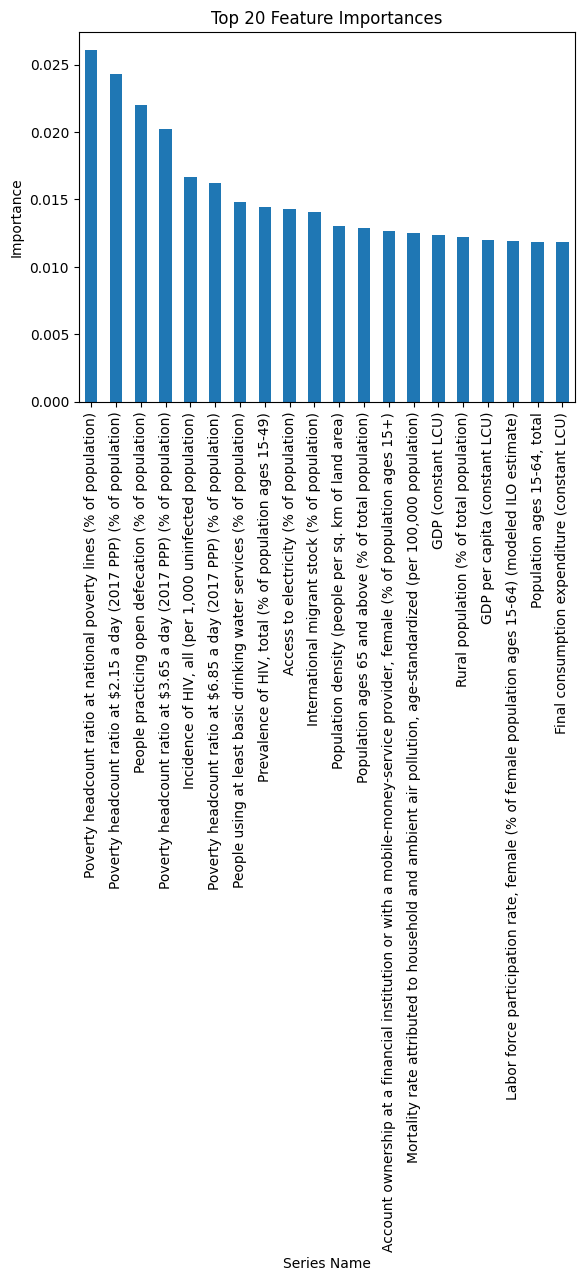

In [72]:
# Plot
top_20.plot(kind='bar')
plt.title("Top 20 Feature Importances")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

Top features influencing the Gini Index in the model:

- **Poverty Measures** (most important):  
  - 2.15/day, 3.65/day, 6.85/day thresholds  
  - National poverty line

- **Health Indicators**:  
  - HIV incidence/prevalence  
  - Open defecation  
  - Surgical workforce, procedures  
  - Suicide mortality

- **Access & Inclusion**:  
  - Drinking water access  
  - Financial account ownership (esp. women)

- **Demographics & Density**:  
  - Population age groups  
  - Population density  
  - Migrant stock

- **Economic & Environmental**:  
  - GDP  
  - Malaria incidence  
  - Injury-related deaths

Income inequality is closely tied to poverty depth, health access, and basic services.

## Key Questions and Answers

1. **Can we predict a country's Gini Index category based on socioeconomic indicators?**  
   Yes. Using a Random Forest classification model trained on a wide range of development indicators, we achieved over **97% test accuracy** in predicting the Gini Index category of a country. This shows that inequality levels are not random—they can be systematically estimated using the right data.

2. **Which development indicators are the most predictive of income inequality?**  
   The strongest predictors were:
   - Poverty rates (especially below $2.15/day)
   - Access to drinking water and sanitation
   - HIV prevalence and surgical access
   - Financial inclusion (e.g. women with bank accounts)
   - Demographic pressure (e.g. youth share, population density)

3. **How well does a machine learning model perform in classifying inequality levels across countries?**  
   The Random Forest model reached **93.2% accuracy on training data** and **97.2% on test data**, showing excellent generalization with no significant signs of overfitting.

4. **How does inequality relate to basic infrastructure, like access to water and financial services?**  
   Countries with limited access to clean water, sanitation, or banking services tend to exhibit higher income inequality. These infrastructure gaps often reflect broader structural disadvantages that reinforce poverty.

5. **Which domains—poverty, health, infrastructure, demographics—contribute most to explaining inequality?**  
   All four domains played key roles, but poverty indicators and infrastructure access (like electricity, sanitation, and financial services) had the highest overall influence in the model. Health and demographic data added important nuance in specific country profiles.
